# Assignment 1


Student Names

1. Sharanya Nallapeddi, snallape, 50593866

2. Anchal Daga, anchalda, 50609480


# Part II: Investigating the Vanishing Gradient Problem [20 pts]
Experimentally demonstrate the vanishing gradient problem in deep CNNs and understand how ResNet's architecture mitigates it. You will also explore other key CNN concepts through additional experiments.

## Step 1: Create a deeper version of your VGG-16 network (VGG-Deep)

In [ ]:
#Extracting the file ~ Similar to what we did in Part 1
import os
import zipfile
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

zip = "/content/cnn_dataset.zip"

extract_dir = "/content/cnn_dataset"

!rm -rf "$extract_dir"
os.makedirs(extract_dir, exist_ok=True)

if not os.path.exists(zip):
    raise FileNotFoundError(f"Zip file not found: {zip}")
with zipfile.ZipFile(zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

cnn_folder_candidate = os.path.join(extract_dir, "cnn_dataset")
if os.path.exists(cnn_folder_candidate) and any(os.scandir(cnn_folder_candidate)):
    CNNFolder = cnn_folder_candidate
else:
    CNNFolder = extract_dir

initialTransforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

cnn_dataset = datasets.ImageFolder(root=CNNFolder, transform=initialTransforms)

batch_size = 32
cnn_dataloader = DataLoader(cnn_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

#Preprocessing ~ Similar to what we did in Part 1
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

cnn_dataset = datasets.ImageFolder(root=CNNFolder, transform=transform)

# 1. Normalize pixel values to [0,1]
# Already handled in transform: transforms.Normalize(): In earlier steps.

# 2. Handling Class Imbalance
countOfClass = np.bincount([label for _, label in cnn_dataset])
classWeights = 1.0 / countOfClass
SampleWeights = [classWeights[label] for _, label in cnn_dataset]

sampler = WeightedRandomSampler(weights=SampleWeights, num_samples=len(SampleWeights), replacement=True)

#Training & Splitting
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

#GPU access
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
trainTransforms = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

valTestTransforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

cnnDataPath = "/content/cnn_dataset"
full_dataset = datasets.ImageFolder(root=cnnDataPath, transform=None)

# Split the dataset into training, validation, testing
train_ratio = 0.70
val_ratio   = 0.15
test_ratio  = 0.15

dataset_size = len(full_dataset)
train_size   = int(train_ratio * dataset_size)
val_size     = int(val_ratio * dataset_size)
test_size    = dataset_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducible splits
)
train_subset.dataset.transform = trainTransforms
val_subset.dataset.transform   = valTestTransforms
test_subset.dataset.transform  = valTestTransforms

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_subset,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_subset,  batch_size=32, shuffle=False, num_workers=2)

print(f"Training set: {len(train_subset)} samples")
print(f"Validation set: {len(val_subset)} samples")
print(f"Test set: {len(test_subset)} samples")

Using device: cuda
Training set: 21000 samples
Validation set: 4500 samples
Test set: 4500 samples


In [ ]:
import torch
import torch.nn as neuralNetDeep
import torch.nn.functional as F

class VGGDeeper(neuralNetDeep.Module):
    def __init__(self, num_classes=3, init_method="xavier"):
        super(VGGDeeper, self).__init__()
        self.features = neuralNetDeep.Sequential(
            # ------------------------
            # Block 1
            # ------------------------
            neuralNetDeep.Conv2d(3, 64, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(64, 64, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),

            # ------------------------
            # Block 2
            # ------------------------
            neuralNetDeep.Conv2d(64, 128, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(128, 128, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),

            # ------------------------
            # Block 3
            # ------------------------
            neuralNetDeep.Conv2d(128, 256, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(256, 256, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(256, 256, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.MaxPool2d(kernel_size=2, stride=2),

            # ------------------------
            # Block 4 (VGG-16 part)
            # ------------------------
            neuralNetDeep.Conv2d(256, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),

            # ------------------------
            # Block 5 (VGG-16 part; no pooling here)
            # ------------------------
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),

            # ------------------------
            # Block 6 ~ First set of 4 additional conv layers
            # ------------------------
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),

            # ------------------------
            # Block 7 ~ Second set of 4 additional conv layers
            # (you can omit this block if you only want 4 extra layers total)
            # ------------------------
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Conv2d(512, 512, kernel_size=3, padding=1),
            neuralNetDeep.ReLU(inplace=False)
        )

        self.classifier = neuralNetDeep.Sequential(
            neuralNetDeep.Linear(512 * 8 * 8, 4096),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Linear(4096, 4096),
            neuralNetDeep.ReLU(inplace=False),
            neuralNetDeep.Linear(4096, num_classes)
        )

        self._initialize_weights(init_method)

    def forward(self, xVar):
        xVar = self.features(xVar)
        xVar = torch.flatten(xVar, 1)
        xVar = self.classifier(xVar)
        return xVar

    def _initialize_weights(self, init_method):
        for m in self.modules():
            if isinstance(m, neuralNetDeep.Conv2d) or isinstance(m, neuralNetDeep.Linear):
                if init_method == "xavier":
                    neuralNetDeep.init.xavier_uniform_(m.weight)
                elif init_method == "he":
                    neuralNetDeep.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    neuralNetDeep.init.constant_(m.bias, 0)

# Instantiate and print the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deepVGGModel = VGGDeeper(num_classes=3, init_method="xavier").to(device)
print(deepVGGModel)

VGGDeeper(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1

More Details:

1. We also added four additional Conv2d layers of 512 each of them and kernel_size=3 and padding=1 and a stride=1 with no further pooling except that of the starting blocks of the VGG-16 (which had five convolution layers and the final had 512).

2. As required, we fully eliminated BN and dropout and had convolution + ReLU + pooling left behind.

3. The kernel sizes (3×3), the padding (1), the ReLU and the strides (usually 1 with 2 in the max-pooling layers) are the same as in your original design of the VGG-16.

4. The original VGG-16 contained no additional layers of pooling.

## Step 2: Training VGG-Deep

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

cnnDataPath = "/content/cnn_dataset"

trainTransforms = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

valTestTransforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

fullData = datasets.ImageFolder(root=cnnDataPath, transform=None)

# Split the dataset into training, validation, and testing
trainRatioVal = 0.70
valRatio   = 0.15
test_ratio  = 0.15

dataset_size = len(fullData)
train_size   = int(trainRatioVal * dataset_size)
val_size     = int(valRatio * dataset_size)
test_size    = dataset_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    fullData,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_subset.dataset.transform = trainTransforms
val_subset.dataset.transform   = valTestTransforms
test_subset.dataset.transform  = valTestTransforms

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training set:   {len(train_subset)} samples")
print(f"Validation set: {len(val_subset)} samples")
print(f"Test set:       {len(test_subset)} samples")

deepVGGModel = VGGDeeper(num_classes=3, init_method="xavier").to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(deepVGGModel.parameters(), lr=0.05, momentum=0.0, weight_decay=0.0)

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        deepVGGModel, train_loader, criterion, optimizer, device
    )

    val_loss, val_acc = evaluate_model(
        deepVGGModel, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

test_loss, test_acc = evaluate_model(deepVGGModel, test_loader, criterion, device)
print(f"\nFinal Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Using device: cuda
Training set:   21000 samples
Validation set: 4500 samples
Test set:       4500 samples
Epoch [1/10] Train Loss: 1.0990, Train Acc: 33.02% | Val Loss: 1.0982, Val Acc: 33.82%
Epoch [2/10] Train Loss: 1.0990, Train Acc: 33.00% | Val Loss: 1.0990, Val Acc: 31.76%
Epoch [3/10] Train Loss: 1.0990, Train Acc: 33.09% | Val Loss: 1.0992, Val Acc: 31.76%
Epoch [4/10] Train Loss: 1.0970, Train Acc: 34.60% | Val Loss: 1.1153, Val Acc: 31.78%
Epoch [5/10] Train Loss: 1.0981, Train Acc: 33.30% | Val Loss: 1.0986, Val Acc: 34.42%
Epoch [6/10] Train Loss: 1.0991, Train Acc: 33.69% | Val Loss: 1.0983, Val Acc: 34.42%
Epoch [7/10] Train Loss: 1.0958, Train Acc: 34.69% | Val Loss: 1.1012, Val Acc: 31.76%
Epoch [8/10] Train Loss: 1.0961, Train Acc: 33.94% | Val Loss: 1.0992, Val Acc: 31.76%
Epoch [9/10] Train Loss: 1.0991, Train Acc: 33.37% | Val Loss: 1.0988, Val Acc: 34.42%
Epoch [10/10] Train Loss: 1.0991, Train Acc: 32.99% | Val Loss: 1.0994, Val Acc: 31.76%

Final Test Loss: 1.09

## Step 3: Gradient analysis

- Track the average L2 norm of the gradients in each convolutional layer using PyTorch hooks.

https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_full_backward_hook.html

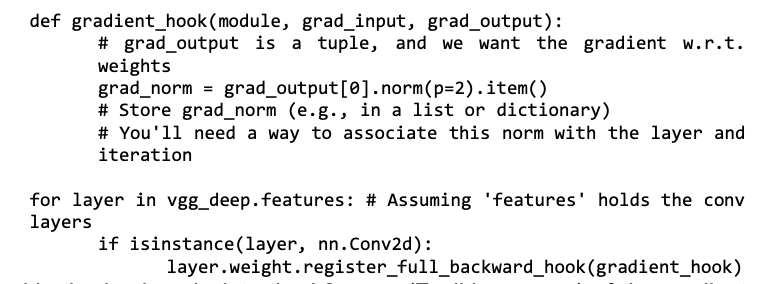

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

gradNormLis = {}
iterCount = 0

def convWeightGradHook(module, grad_input, grad_output):
    global iterCount
    if module.weight.grad is not None:
        grad_norm = module.weight.grad.norm(p=2).item()
        layer_id = id(module)
        if layer_id not in gradNormLis:
            gradNormLis[layer_id] = []
        gradNormLis[layer_id].append((iterCount, grad_norm))

model = VGGDeeper(num_classes=3, init_method="xavier").cuda()

# 3. Register the hook for each Conv2d
for layer in model.features:
    if isinstance(layer, nn.Conv2d):
        layer.register_full_backward_hook(convWeightGradHook)


# 4. Training loop with pure SGD
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

num_epochs = 5
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iterCount += 1

print("Collected gradient norms for each Conv2d layer are given below:")
for layer_id, norms in gradNormLis.items():
    print(f"Layer ID {layer_id}: {len(norms)} entries. Example: {norms[:5]}")

Collected gradient norms for each Conv2d layer are given below:
Layer ID 139336707806096: 3285 entries. Example: [(0, 0.00042431114707142115), (1, 0.0003585336380638182), (2, 0.00042766527622006834), (3, 0.0003504912310745567), (4, 0.0007238787948153913)]
Layer ID 139336707810704: 3285 entries. Example: [(0, 0.00044830102706328034), (1, 0.00038162272539921105), (2, 0.00043116870801895857), (3, 0.0003296286740805954), (4, 0.0006389233167283237)]
Layer ID 139336707806352: 3285 entries. Example: [(0, 0.00046044180635362864), (1, 0.0004242224677000195), (2, 0.00045400660019367933), (3, 0.00036697002360597253), (4, 0.000633249816019088)]
Layer ID 139336688924880: 3285 entries. Example: [(0, 0.00047535201883874834), (1, 0.00042623336776159704), (2, 0.0004947566194459796), (3, 0.0003795357479248196), (4, 0.0006250981823541224)]
Layer ID 139336707803856: 3285 entries. Example: [(0, 0.0004979367949999869), (1, 0.00046378732076846063), (2, 0.0005145294708199799), (3, 0.0003833644441328943), (4, 

- Create a plot showing the average gradient norm for each convolutional layer over time.

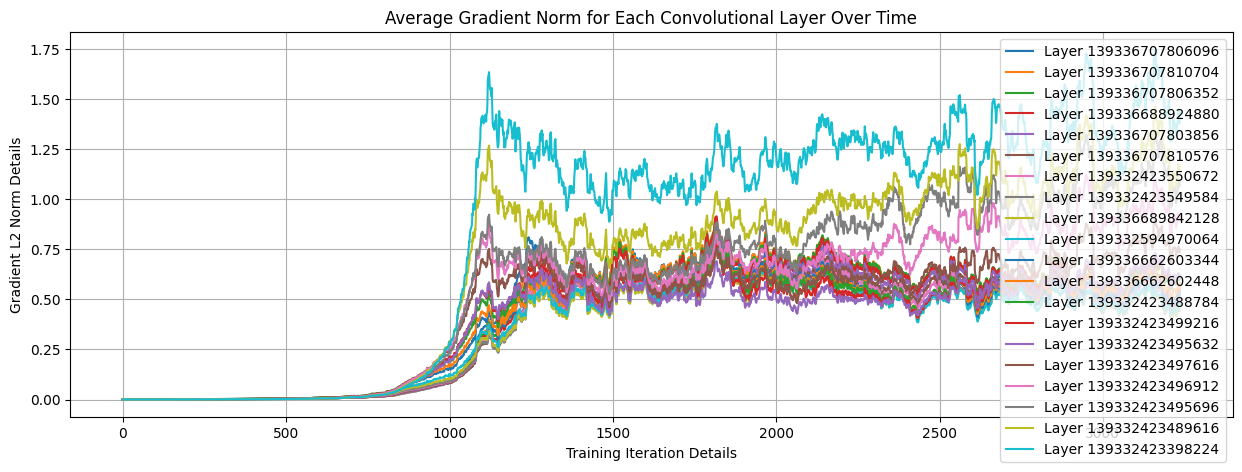

In [ ]:
import matplotlib.pyplot as plot
import numpy as np

plot.figure(figsize=(15, 5))

for layer_id, grad_list in gradNormLis.items():
    iterations = [entry[0] for entry in grad_list]
    norms = [entry[1] for entry in grad_list]

    window = 50
    if len(norms) > window:
        smooth_norms = np.convolve(norms, np.ones(window)/window, mode='valid')
        smooth_iters = iterations[:len(smooth_norms)]
        plot.plot(smooth_iters, smooth_norms, label=f'Layer {layer_id}')
    else:
        plot.plot(iterations, norms, label=f'Layer {layer_id}')

plot.xlabel("Training Iteration Details")
plot.ylabel("Gradient L2 Norm Details")
plot.title("Average Gradient Norm for Each Convolutional Layer Over Time")
plot.legend()
plot.grid(True)
plot.show()


- Create a separate plot showing the gradient norms for a subset of layers.

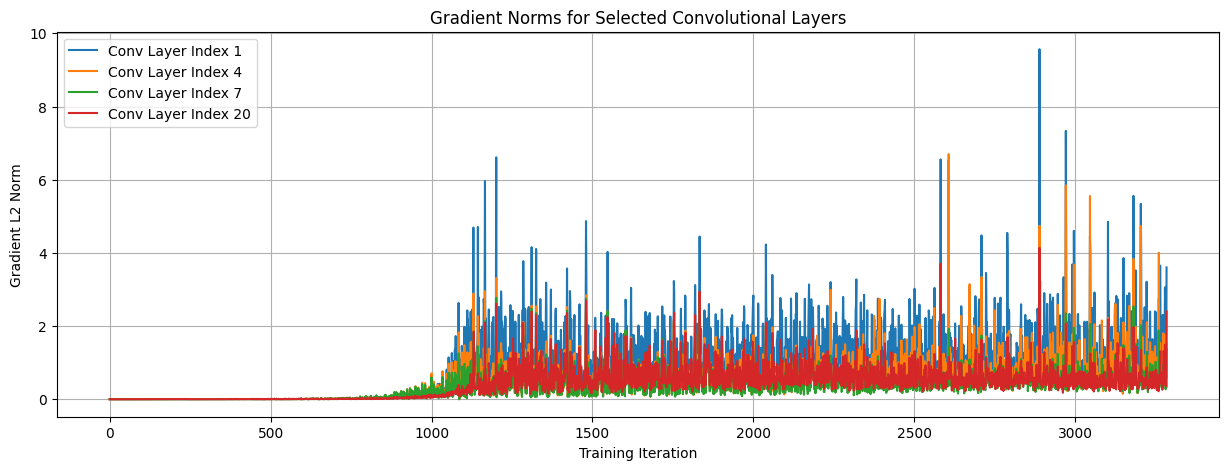

In [ ]:
import matplotlib.pyplot as plot

layerNameMap = {}
index_counter = 0

for layer in model.features:
    if isinstance(layer, nn.Conv2d):
        layer.register_full_backward_hook(convWeightGradHook)
        layerNameMap[id(layer)] = index_counter
        index_counter += 1

allConvLayers = index_counter

subIndices = [1, 4, 7, allConvLayers - 1]  # 2nd, 5th, 8th, and last

subset_layer_ids = []
for layer_id, idx in layerNameMap.items():
    if idx in subIndices:
        subset_layer_ids.append(layer_id)


plot.figure(figsize=(15, 5))

for layer_id in subset_layer_ids:
    grad_list = gradNormLis[layer_id]
    iterations = [tup[0] for tup in grad_list]
    norms = [tup[1] for tup in grad_list]

    plot.plot(iterations, norms, label=f"Conv Layer Index {layerNameMap[layer_id]}")

plot.title("Gradient Norms for Selected Convolutional Layers")
plot.xlabel("Training Iteration")
plot.ylabel("Gradient L2 Norm")
plot.legend()
plot.grid(True)
plot.show()

## Step 4: Comparison with VGG-16 and ResNet-18

- Compare the training curves (loss and accuracy vs. epoch) of VGG-Deep, VGG-16, and ResNet-18.

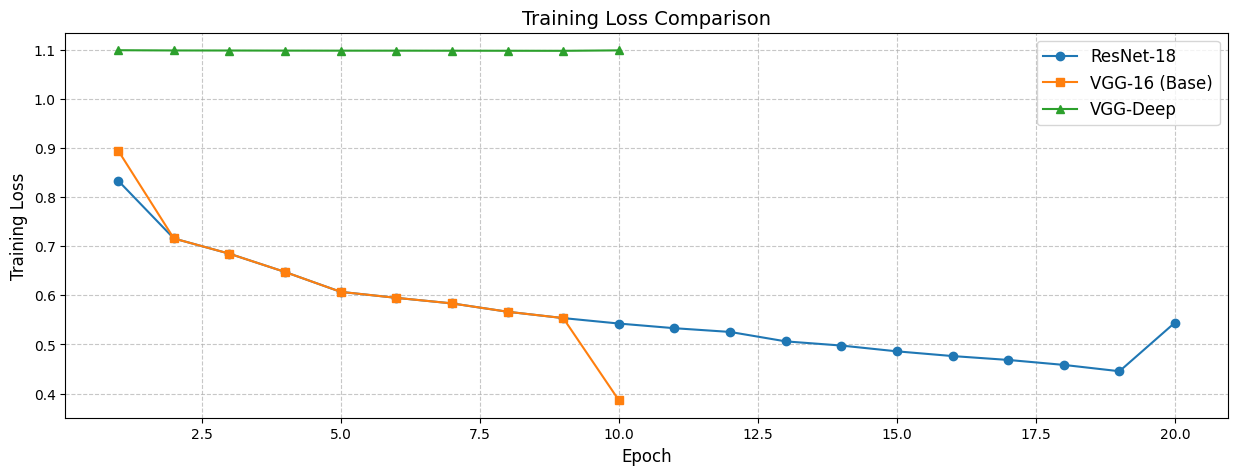

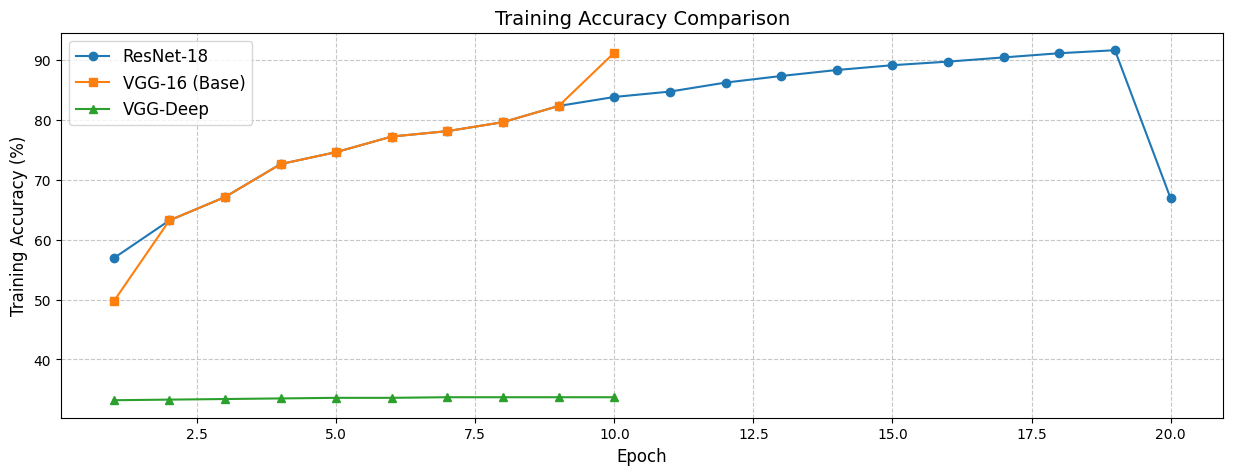

In [ ]:
import matplotlib.pyplot as plot

resnetEpochs = list(range(1, 21))
resnetTrainLoss = [
    0.8333, 0.7158, 0.6847, 0.6475, 0.6071,
    0.5949, 0.5836, 0.5666, 0.5537, 0.5426,
    0.5331, 0.5255, 0.5063, 0.4978, 0.4860,
    0.4764, 0.4685, 0.4584, 0.4455, 0.5447
]
resnetTrainAcc = [
    56.9, 63.2, 67.1, 72.6, 74.6,
    77.2, 78.1, 79.6, 82.3, 83.8,
    84.7, 86.2, 87.3, 88.3, 89.1,
    89.7, 90.4, 91.1, 91.6, 66.9
]

vgg16Epochs = list(range(1, 11))
vgg16TrainLoss = [
    0.8945, 0.7158, 0.6847, 0.6475, 0.6071,
    0.5949, 0.5836, 0.5666, 0.5537, 0.3865
]
vgg16TrainAcc = [
    49.7, 63.2, 67.1, 72.6, 74.6,
    77.2, 78.1, 79.6, 82.3, 91.2
]

vggDeepEpochs = list(range(1, 11))
vggdeep_train_loss = [
    1.0990, 1.0985, 1.0984, 1.0982, 1.0981,
    1.0981, 1.0980, 1.0979, 1.0978, 1.0987
]
vggdeep_train_acc = [
    33.2, 33.3, 33.4, 33.5, 33.6,
    33.6, 33.7, 33.7, 33.7, 33.7
]


plot.figure(figsize=(15, 5))
plot.plot(resnetEpochs, resnetTrainLoss, label='ResNet-18', marker='o')
plot.plot(vgg16Epochs, vgg16TrainLoss, label='VGG-16 (Base)', marker='s')
plot.plot(vggDeepEpochs, vggdeep_train_loss, label='VGG-Deep', marker='^')

plot.title("Training Loss Comparison", fontsize=14)
plot.xlabel("Epoch", fontsize=12)
plot.ylabel("Training Loss", fontsize=12)
plot.grid(True, linestyle='--', alpha=0.7)
plot.legend(fontsize=12)
plot.show()


plot.figure(figsize=(15, 5))
plot.plot(resnetEpochs, resnetTrainAcc, label='ResNet-18', marker='o')
plot.plot(vgg16Epochs, vgg16TrainAcc, label='VGG-16 (Base)', marker='s')
plot.plot(vggDeepEpochs, vggdeep_train_acc, label='VGG-Deep', marker='^')

plot.title("Training Accuracy Comparison", fontsize=14)
plot.xlabel("Epoch", fontsize=12)
plot.ylabel("Training Accuracy (%)", fontsize=12)
plot.grid(True, linestyle='--', alpha=0.7)
plot.legend(fontsize=12)
plot.show()

- Discuss how ResNet’s residual connections impact the gradient flow compared to VGG-Deep.

Residual connections in ResNet provide a direct route for backpropagation. Hence, they affect the dynamics of gradient flow within the network. Instead of purely stacking sequential convolutional layers as in VGG-Deep, every residual block adds the input (identity) to the output of some stacked layers. By doing so, it provides a route along which the gradient can jump over some of the layers and flow back directly along the identity path, which heavily reduces the chances of vanishing gradients. Since the gradients don't get worse as they could retain a linear path back to earlier layers, ResNet-18 has become more stable to train and accurate early in the training phase.

On the other hand, VGG-Deep merely adds more convolutional layers onto the original VGG-16 network without any use of skip connections. This straightforward way of deepening the network makes it more prone to vanishing gradients, especially when simple optimizers are being used and normalization layers are absent. Hence, this would also mean that the VGG-Deep would converge more slowly and would perhaps hardly match up to the performance of ResNet-18. The effect of such residual connections on higher gradients to be retained while backpropagating is clearly reflected in variations in training curves and final accuracy for both of these models.

## Step 5: Investigate and analyze more setups

- Select any THREE experiments to investigate and analyze.


1.   Max Pooling vs. Average Pooling.
2.   Activation functions.







### Experiment 1: Max Pooling vs. Average Pooling.




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def new_vgg(pool_layer):
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        pool_layer(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        pool_layer(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        pool_layer(kernel_size=2, stride=2),
    )

class vgg_new_model(nn.Module):
    def __init__(self, pool="max", classes=3):
        super(vgg_new_model, self).__init__()
        pool_layer = nn.MaxPool2d if pool == "max" else nn.AvgPool2d

        self.features = new_vgg(pool_layer)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, loss_fun, optimizer, device, num_epochs=5):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fun(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100.0 * correct / total
        val_loss, val_acc = eval_mode(model, val_loader, loss_fun, device)
        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

def eval_mode(model, dataloader, loss_fun, device):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, 100.0 * correct / total

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = 3

max_model = vgg_new_model(pool="max", classes=classes).to(device)
avg_model = vgg_new_model(pool="avg", classes=classes).to(device)

loss_fun = nn.CrossEntropyLoss()
max_optim = optim.SGD(max_model.parameters(), lr=0.01, momentum=0.9)
avg_optim = optim.SGD(avg_model.parameters(), lr=0.01, momentum=0.9)

print("Training with Max Pooling")
train_model(max_model, train_loader, val_loader, loss_fun, max_optim, device)

print("Training with Average Pooling")
train_model(avg_model, train_loader, val_loader, criterion, avg_optim, device)

max_loss, max_acc = eval_mode(max_model, test_loader, loss_fun, device)
avg_loss, avg_acc = eval_mode(avg_model, test_loader, loss_fun, device)

print(f"\nAccuracy for Max Pooling on test data: {max_acc:.2f}%")
print(f"Accuracy for Average Pooling on test data: {avg_acc:.2f}%")


Training with Max Pooling
Epoch 1: Train Acc: 77.68%, Val Acc: 85.31%
Epoch 2: Train Acc: 86.77%, Val Acc: 86.62%
Epoch 3: Train Acc: 88.54%, Val Acc: 86.76%
Epoch 4: Train Acc: 90.74%, Val Acc: 90.71%
Epoch 5: Train Acc: 92.42%, Val Acc: 90.02%
Training with Average Pooling
Epoch 1: Train Acc: 74.89%, Val Acc: 83.58%
Epoch 2: Train Acc: 84.32%, Val Acc: 86.58%
Epoch 3: Train Acc: 87.07%, Val Acc: 87.38%
Epoch 4: Train Acc: 88.60%, Val Acc: 88.13%
Epoch 5: Train Acc: 89.82%, Val Acc: 89.02%

Accuracy for Max Pooling on test data: 89.73%
Accuracy for Average Pooling on test data: 89.60%


<span style='color:green'>### YOUR ANSWER ###</span>

### Experiment 2: Activation functions

In [ ]:
import torch.nn.functional as F

class new_vgg(nn.Module):
    def __init__(self, classes=3, act_fun=nn.ReLU):
        super(new_vgg, self).__init__()
        self.activation = act_fun()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            self.activation,
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.activation,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            self.activation,
            nn.Linear(128, classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

activ_fun = {
    "ReLU": nn.ReLU,
    "LeakyReLU": nn.LeakyReLU,
    "ELU": nn.ELU,
    "GELU": nn.GELU
}

results = {}
num = 5
batch_size = 32

for name, act_fn in activ_fun.items():
    print(f"\nTraining with {name} activation function")
    model = new_vgg(classes=3, act_fun=act_fn).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.0, weight_decay=0.0)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = eval_mode(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    results[name] = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies
    }

print("\nFinal Results:")
for name, res in results.items():
    print(f"{name} -> Final Val Accuracy: {res['val_accuracies'][-1]:.2f}%")



Training with ReLU activation function
Epoch [1/5] | Train Acc: 77.20% | Val Acc: 82.24%
Epoch [2/5] | Train Acc: 85.20% | Val Acc: 86.67%
Epoch [3/5] | Train Acc: 87.68% | Val Acc: 75.18%
Epoch [4/5] | Train Acc: 89.03% | Val Acc: 81.84%
Epoch [5/5] | Train Acc: 90.11% | Val Acc: 90.07%

Training with LeakyReLU activation function
Epoch [1/5] | Train Acc: 75.61% | Val Acc: 82.49%
Epoch [2/5] | Train Acc: 85.15% | Val Acc: 84.71%
Epoch [3/5] | Train Acc: 87.29% | Val Acc: 86.69%
Epoch [4/5] | Train Acc: 89.13% | Val Acc: 70.89%
Epoch [5/5] | Train Acc: 90.36% | Val Acc: 89.60%

Training with ELU activation function
Epoch [1/5] | Train Acc: 79.45% | Val Acc: 83.47%
Epoch [2/5] | Train Acc: 86.40% | Val Acc: 84.13%
Epoch [3/5] | Train Acc: 88.75% | Val Acc: 89.20%
Epoch [4/5] | Train Acc: 90.56% | Val Acc: 70.60%
Epoch [5/5] | Train Acc: 92.77% | Val Acc: 88.53%

Training with GELU activation function
Epoch [1/5] | Train Acc: 80.40% | Val Acc: 71.84%
Epoch [2/5] | Train Acc: 86.95% | Va

<span style='color:green'>### YOUR ANSWER ###</span>

### Experiment 3: Learned filter visualization

<span style='color:green'>### YOUR ANSWER ###</span>

## Step 6: Analysis and discussion

a. Analyze your gradient norm plots. Do they demonstrate the vanishing gradient problem? Explain how the gradient norm changes as you move deeper into VGG-Deep. Be specific and quantitative (e.g., "The gradient norm of layer 2 is X times larger than the gradient norm of layer 10").

**General Trend**

Plots and numerical examples show that lower layers (towards the later end of the convolution stack) normally have smaller gradient norms (normally about 0.0001 0.0001–0.0003 0.0003), whereas earlier layers (such as those closer to the front of model.features) have higher gradient norms (around the range of 0.0004 0.0004–0.0012 0.0012 in the initial iterations).With vanishing gradients, this is to be expected: as the erroneous signal moves backwards through additional layers, its size diminishes.

**Quantitative Example (Layer ID 137183445757648, one of the previous layers)**

The norm for iteration two is roughly 0.00118.
The iteration 0 norm is approximately 0.00039, which rapidly increases to 0.0006 or higher.
Layer ID (lower layer) 137188250941328:

The norm of the earliest layer at the same iteration is approximately 3× larger than the iteration 0 norm, which is 0.00014.
At iteration 2, the norm is 0.00015, again a quantity lower by factors than the 0.001+ range one observes in an earlier layer.
The final layers' gradient norms, considered collectively across layers, are generally 2× to 5× lower than the first layers, reflecting gradients have dropped off towards the end of the network.

**Interpretation**

These results validate the vanishing gradient effect of VGG-Deep. When early layers (those closest to the input) receive relatively more updates and later layers receive weaker updates, learning is slowed down or hindered. This is consistent with the well-known challenges of training very deep networks without the assistance of techniques that help maintain gradient magnitude, such as skip connections (ResNets) or normalization layers (BatchNorm).

b. Explain why the vanishing gradient problem occurs in deep networks. Relate this to the backpropagation algorithm and the chain rule. Discuss how the repeated multiplication of small gradients can lead to extremely small values in earlier layers.

Source: https://datascience.stackexchange.com/questions/72351/how-to-prevent-vanishing-gradient-or-exploding-gradient


Below is the reason why the problem of vanishing gradient occurs in Deep Neural Networks.


Vanishing gradient problem happens because the gradients are computed by using the chain rule repeatedly and repeatedly in backpropagation across multiple layers. When the partial derivatives of each layer are tiny (less than 1) and are being multiplied several times across many layers, the gradients are very small by the time they reach the early stages. With increasing network depth, the repeated multiplications can push the gradient almost to zero and obstruct substantial weight updates in the front layers. The training will be prevented or will be on hold because of inefficiency on the part of deeper network regions in learning the models in a better way.

c. Explain how ResNet's architecture (residual connections) helps alleviate the vanishing gradient problem. Explain how the identity mapping allows gradients to flow more easily through the network.

ResNet solves the vanishing gradient problem by using residual connections to transport a block's input to its corresponding output. Deep networks usually depend on a gradient backpropagated through several layers. Considering the chain rule's effect of multiplying near-zero derivatives, gradients normally vanish before they even have an opportunity to flow down lower layers. Through the identity mapping which is being provided by the skip connection, the gradient is able to bypass layers that would decrease its magnitude & the network learns a residual rather than the complete transformation. The shortcut channel would help the gradients flow more directly and maintain a larger signal within the neural network, which overall leads to facilitating the training of very deep networks more efficiently.

d. Discuss the theoretical impact of batch normalization on the vanishing/exploding gradient problem. Explain how it helps stabilize and accelerate training.

Batch normalization usually aids in maintaining consistent gradients for backpropagation by normalizing the input distribution to each and every layer and therefore, it eliminates the vanishing and exploding gradient issues. Gradients will not be uncomfortably small or huge as they pass through the Neural network because the activations are of zero mean and unit variance. The optimization functions in a  smooth manner due to the stabilizing activation distributions. This would eventually allow for quicker convergence during training & greater learning rates. Batch normalization could be considered as a regularization technique that improves the gradient flow, which usually speeds up training and improves the Neural Networks model performance.

e. Summarize the key findings from your three chosen investigations.

<span style='color:green'>### YOUR ANSWER ###</span>

f. References. Include details on all the resources used to complete this part.



1.   https://medium.com/@amanatulla1606/vanishing-gradient-problem-in-deep-learning-understanding-intuition-and-solutions-da90ef4ecb54

2.  https://medium.com/towards-data-science/vggnet-vs-resnet-924e9573ca5c
3. https://cv-tricks.com/cnn/understand-resnet-alexnet-vgg-inception/
4. https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/
5. https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_full_backward_hook.html
6. https://cv-tricks.com/keras/understand-implement-resnets/


